# Clean the data
Load the data and clean it using the BDT

In [1]:
import joblib
import uproot
import boost_histogram as bh
import matplotlib.pyplot as plt
import awkward as ak
import pickle
import numpy as np

In [2]:
def get_config(is_jaguar=True):
    """
        histograms_path = Set the path to store the histograms
        model_path = Set the path to load the BDT to clean the data
        response_matrix_path = Set the path to read the response matrix
    """
    # histograms configuration
    config = {
        "hist" : {
            "nbins" : 50,
            "rmin" : 0.2,
            "rmax" : 1.8
        }
    }
    if is_jaguar:
        print("Loading configuration to run in Jaguar")
        config["data"] = {
            "files" : "/storage/cpegueros/tau2pipi0_taupair_1623721564_00/sub00/data40/*.root",
            "workers" : 45,
            "step_size" : "500 MB"
        }
        config["model_path"] = "/home/cpegueros/bdt/gradient_1627111793.joblib"
        config["histograms_path"] = "/home/cpegueros/thesis/tau2pipi0nu_data_to_unfold.pkl"
        config["response_matrix_path"] = "/home/cpegueros/thesis/tau2pipi0nu_response_matrix.pkl"
    else:
        print("Loading configuration to run in local. No data will be available.")
        config["data"] = {
            "files" : None,
            "workers" : None,
            "step_size" : None
        }
        config["model_path"] = "/home/peguerosdc/development/thesis/data/gradient_1627111793.joblib"
        config["histograms_path"] = "/home/peguerosdc/development/thesis/data/tau2pipi0nu_data_to_unfold.pkl"
        config["response_matrix_path"] = "/home/peguerosdc/development/thesis/data/tau2pipi0nu_response_matrix.pkl"
    return config

In [3]:
config = get_config(is_jaguar=True)

Loading configuration to run in Jaguar


In [12]:
# Amount of bins and histogram limits
nbins, rmin, rmax = config["hist"]["nbins"], config["hist"]["rmin"], config["hist"]["rmax"]

# Histogram to store the raw data
data_raw_invM = bh.Histogram(bh.axis.Regular(nbins, rmin, rmax))
data_raw_invM_mc = bh.Histogram(bh.axis.Regular(nbins, rmin, rmax))

# Histogram to store the data after a weak cleaning
data_weak_invM = bh.Histogram(bh.axis.Regular(nbins, rmin, rmax))
data_weak_invM_mc = bh.Histogram(bh.axis.Regular(nbins, rmin, rmax))

# Histogram to store the data after a strict cleaning
data_strict_invM = bh.Histogram(bh.axis.Regular(nbins, rmin, rmax))
data_strict_invM_mc = bh.Histogram(bh.axis.Regular(nbins, rmin, rmax))

Use the trained BDT to clean the data and build its histograms. Use two versions:

1. One with the default threshold for the BDT, where the class, `signal` or `background`, with the highest probability is taken
2. One with a stricter Punzi threshold where only `signal` with a probability higher than 81.2% is taken

In [13]:
# load the BDT
bdt = joblib.load(config["model_path"])

# variables to load from the data
branches_to_train = ["thrust","visibleEnergyOfEventCMS","track_sig_EoverP","track_sig_pionID","track_sig_pt", "sig_gamma1_E","sig_gamma2_E","track_sig_cosToThrustOfEvent","neutral_sig_E","neutral_sig_M"]
branches_to_cut = ["nPi0s_sig"]
branch_of_interest = ["tau_sig_InvM", "tau_sig_matchedMC_InvM"]
branches_mc = ["track_sig_charge", "tauPlusMCMode", "tauMinusMCMode"]
branches_to_load = branches_to_train + branches_to_cut + branch_of_interest + branches_mc

for df in uproot.iterate(f"{config['data']['files']}:tau1x1", filter_name=branches_to_load, step_size=config["data"]["step_size"], num_workers=config["data"]["workers"]):
    # filter events with one pi0
    one_pi0 = df[ (df.nPi0s_sig == 1) ]
    data_to_clean = ak.to_pandas(one_pi0)[branches_to_train]
    data_raw_invM.fill(one_pi0.tau_sig_InvM)
    data_raw_invM_mc.fill(one_pi0.tau_sig_matchedMC_InvM)
    # convert to pandas and apply two versions of the BDT:
    # - a weak one with the default threshold
    label_weak = bdt.predict(data_to_clean)
    data_weak_invM.fill( one_pi0.tau_sig_InvM[(label_weak==1)] )
    data_weak_invM_mc.fill(one_pi0.tau_sig_matchedMC_InvM[(label_weak==1)])
    # - a stricter one with a Punzi threshold
    threshold = 0.8124348178431804
    label_strict = (bdt.predict_proba(data_to_clean) >= threshold)
    data_strict_invM.fill( one_pi0.tau_sig_InvM[label_strict[:,1]] )
    data_strict_invM_mc.fill(one_pi0.tau_sig_matchedMC_InvM[(label_strict[:,1])])

# Save a tuple containing these histograms in a Pickle file
with open(config["histograms_path"], 'wb') as output:
    temp = {
        "data_raw_invM" : data_raw_invM,
        "data_raw_invM_mc" : data_raw_invM_mc,
        "data_weak_invM" : data_weak_invM,
        "data_weak_invM_mc" : data_weak_invM_mc,
        "data_strict_invM" : data_strict_invM,
        "data_strict_invM_mc" : data_strict_invM_mc,
    }
    pickle.dump(temp, output)
    print(f"Histograms saved to {config["histograms_path"]}")

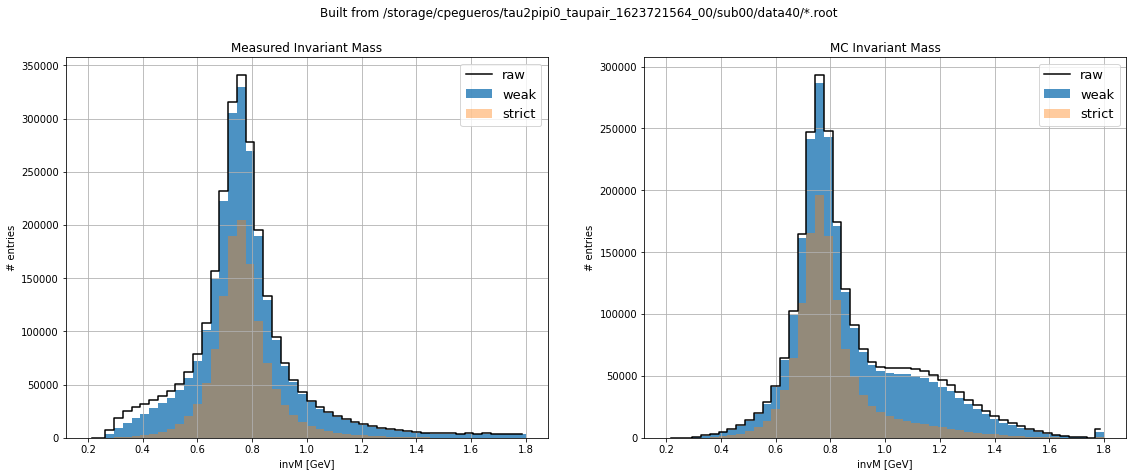

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(19, 7))
fig.suptitle(f"Built from {config['data']['files']}")

# Plot the histograms of the data before and after BDT
ax_data = axs[0]
ax_data.step(data_raw_invM.axes[0].centers, data_raw_invM.view(), color="black", label="raw", where="mid")
ax_data.bar(data_weak_invM.axes[0].centers, data_weak_invM.view(), width=data_weak_invM.axes[0].widths, label="weak", alpha=0.8)
ax_data.bar(data_strict_invM.axes[0].centers, data_strict_invM.view(), width=data_strict_invM.axes[0].widths, label="strict", alpha=0.4)
ax_data.grid()
ax_data.set_xlabel("invM [GeV]")
ax_data.set_ylabel("# entries")
ax_data.set_title("Measured Invariant Mass")
ax_data.legend(prop={"size": 13})

# Plot the histograms of how signal and bg is distributed after BDT
ax_eval = axs[1]
ax_eval.step(data_raw_invM_mc.axes[0].centers, data_raw_invM_mc.view(), color="black", label="raw", where="mid")
ax_eval.bar(data_weak_invM_mc.axes[0].centers, data_weak_invM_mc.view(), width=data_weak_invM_mc.axes[0].widths, label="weak", alpha=0.8)
ax_eval.bar(data_strict_invM_mc.axes[0].centers, data_strict_invM_mc.view(), width=data_strict_invM_mc.axes[0].widths, label="strict", alpha=0.4)
ax_eval.grid()
ax_eval.set_title("MC Invariant Mass")
ax_eval.set_xlabel("invM [GeV]")
ax_eval.set_ylabel("# entries")
ax_eval.legend(prop={"size": 13})

# Unfolding
Load the response matrix and perform the unfolding

In [3]:
# Unfolding libraries
from unfolders.unfolder import Unfolder
from utils.stats import compute_numpy_covariance_matrix
from unfolders.annealing import (
    SimulatedAnnealingBackend,
    SimulatedQuantumAnnealingBackend,
)
from unfolders.svd import SVDBackend
from doc import plot_utils
plot_utils.setup()

config = get_config(is_jaguar=False)

Welcome to JupyROOT 6.23/01
Loading configuration to run in local. No data will be available.


In [4]:
# First, load the histograms
with open(config["histograms_path"], 'rb') as output:
    temp = pickle.load(output)
    hist_weak_invM_mc = temp["data_weak_invM_mc"]
    # get histograms as numpy arrays
    data_weak_invM, data_weak_invM_bins = temp["data_weak_invM"].to_numpy()
    data_weak_invM_mc, data_weak_invM_mc_bins = hist_weak_invM_mc.to_numpy()
    data_strict_invM, data_strict_invM_bins = temp["data_strict_invM"].to_numpy()
    hist_strict_invM_mc = temp["data_strict_invM_mc"]
    data_strict_invM_mc, data_strict_invM_mc_bins = hist_strict_invM_mc.to_numpy()
    # compute covariance matrix of data to unfold
    statcov_weak = compute_numpy_covariance_matrix(data_weak_invM)
    statcov_strict = compute_numpy_covariance_matrix(data_strict_invM)

# And load the response matrix
with open(config["response_matrix_path"], 'rb') as output:
    response_data = pickle.load(output)
    # transform histograms to numpy arrays
    truth_hist = response_data["truth"]
    truth, truth_bins = truth_hist.to_numpy()
    reco, reco_bins = response_data["reco"].to_numpy()
    R, R_bins_x, R_bins_y = response_data["R"].to_numpy()

## Weak Unfolding
Perform the unfolding on the weak data (the data after using a weak BDT threshold) just as a reference to show why data needs to be clean in order for the unfolding to work

In [22]:
nbins, rmin, rmax = config["hist"]["nbins"], config["hist"]["rmin"], config["hist"]["rmax"]

# Perform the weak unfolding just for reference
unfolder = Unfolder(data_weak_invM, statcov_weak, truth, reco, R)
annealing_result = unfolder.unfold(SimulatedQuantumAnnealingBackend(4, 100, weight_regularization=0.5))
svd_k = 5
svd_backend = SVDBackend(svd_k, rmin, rmax)
svd_result = unfolder.unfold(svd_backend)

/home/peguerosdc/development/thesis/unfolders/annealing/backend.py:243: RuntimeWarning: invalid value encountered in true_divide
  R_probabilities = np.where(xini > 0, np.divide(R, xini), 0)
Info in <TSVDUnfold::Unfold>: Unfolding param: 5
Info in <TSVDUnfold::Unfold>: Curvature of weight distribution: 0.025586


Text(0, 0.5, '# entries')

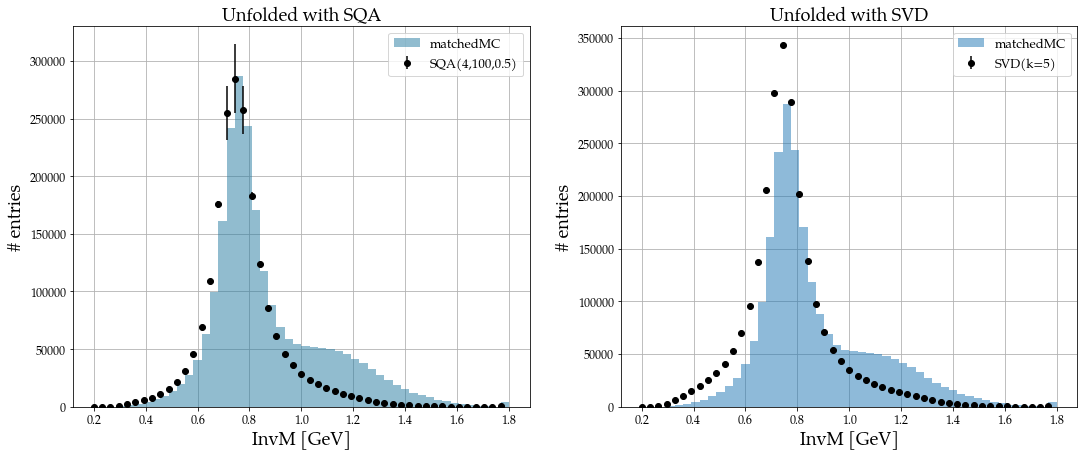

In [26]:
# Plot the result
axis = truth_bins[:-1]
fig, axs = plot_utils.get_1x2_im_figure()
#fig.suptitle(f"Weak Unfolding {config['histograms_path']}")

# Plot the original distribution and the unfolded with annealing
axs[0].bar(hist_weak_invM_mc.axes[0].centers, hist_weak_invM_mc.view(), width=hist_weak_invM_mc.axes[0].widths, color="#247BA0", label="matchedMC", alpha=0.5)
axs[0].errorbar(
    axis,
    annealing_result.solution,
    yerr=annealing_result.error,
    fmt="o",
    color="black",
    label="SQA(4,100,0.5)",
)
axs[0].legend(prop={"size": 13})
#axs[0].grid()
axs[0].set_title("Unfolded with SQA")
axs[0].set_xlabel("InvM [GeV]")
axs[0].set_ylabel("# entries")
# Plot the original distribution and the unfolded with SVD
axs[1].bar(hist_weak_invM_mc.axes[0].centers, hist_weak_invM_mc.view(), width=hist_weak_invM_mc.axes[0].widths, label="matchedMC", alpha=0.5)
axs[1].errorbar(
    axis,
    svd_result.solution,
    yerr=svd_result.error,
    fmt="o",
    color="black",
    label=f"SVD(k={svd_k})",
)
axs[1].legend(prop={"size": 13})
#axs[1].grid()
axs[1].set_title("Unfolded with SVD")
axs[1].set_xlabel("InvM [GeV]")
axs[1].set_ylabel("# entries")

(-1.0, 100.0)

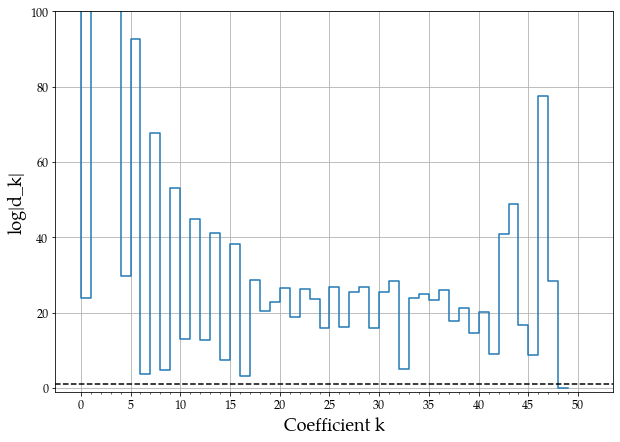

In [25]:
# Plot the kreg distribution
fig, axs = plot_utils.get_1x1_im_figure()
k_ax = axs
k_ax.step(range(0,nbins), svd_backend.kreg_distribution)
#k_ax.set_yscale('log')
k_ax.axline((0,1), (nbins+1,1), color="black", linestyle="--")
#k_ax.grid()
#k_ax.set_title("log|d|")
k_ax.set_xlabel("Coefficient k")
k_ax.set_ylabel("log|d_k|")
_ = k_ax.set_xticks(np.arange(0, nbins+1, 5), minor=False)
_ = k_ax.set_xticks(np.arange(0, nbins+1, 1), minor=True)
k_ax.set_ylim(-1, 100)

## Perform the strict unfolding
Perform the unfolding on the strict data (data after using a Punzi BDT threshold) to see how the unfolding goes

### SVD
Start with SVD as it is simpler

In [17]:
nbins, rmin, rmax = config["hist"]["nbins"], config["hist"]["rmin"], config["hist"]["rmax"]

# Perform the strict SDV unfolding
unfolder = Unfolder(data_strict_invM, statcov_strict, truth, reco, R)
svd_backend = SVDBackend(2, rmin, rmax)
svd_result = unfolder.unfold(svd_backend)

Info in <TSVDUnfold::Unfold>: Unfolding param: 2
Info in <TSVDUnfold::Unfold>: Curvature of weight distribution: 0.000019


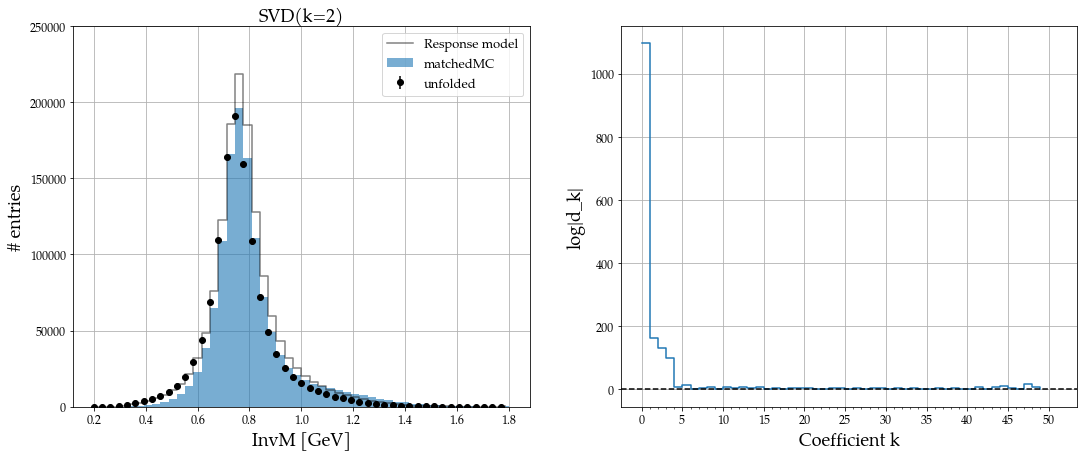

In [18]:
# Plot the result
axis = truth_bins[:-1]
#fig, axs = plt.subplots(1, 2, figsize=(19, 9))
fig, axs = plot_utils.get_1x2_im_figure()
#fig.suptitle(f"Strict Unfolding {config['histograms_path']}")

# Plot the original distribution and the unfolded with SVD
res_ax = axs[0]
res_ax.step(truth_hist.axes[0].centers, truth_hist.view(), color="black", label="Response model", where="mid", alpha=0.5)
res_ax.bar(hist_strict_invM_mc.axes[0].centers, hist_strict_invM_mc.view(), width=hist_strict_invM_mc.axes[0].widths, label="matchedMC", alpha=0.6)
res_ax.errorbar(
    axis,
    svd_result.solution,
    yerr=svd_result.error,
    fmt="o",
    color="black",
    label="unfolded",
)
res_ax.legend(prop={"size": 13})
res_ax.set_title("SVD(k=2)")
res_ax.set_xlabel("InvM [GeV]")
res_ax.set_ylabel("# entries")
res_ax.set_ylim(-1, 250000)

# Plot the kreg distribution to choose the regularization factor
k_ax = axs[1]
k_ax.step(range(0,nbins), svd_backend.kreg_distribution, where="post")
#k_ax.set_yscale('log')
k_ax.axline((0,1), (nbins+1,1), color="black", linestyle="--")
k_ax.set_xlabel("Coefficient k")
k_ax.set_ylabel("log|d_k|")
_ = k_ax.set_xticks(np.arange(0, nbins+1, 5), minor=False)
_ = k_ax.set_xticks(np.arange(0, nbins+1, 1), minor=True)
#k_ax.set_ylim(-1, 100)

In [38]:
# remove zeros
clean_expected = hist_strict_invM_mc.view()[2:]
clean_observed = svd_result.solution[2:]

# Test with a chisquared
from scipy.stats import chisquare
chi, p = chisquare(clean_observed, clean_expected)
print(f"chi_squared = {chi} => p = {p}")

# Get MAPE error
def get_mape(observed, expected):
    return np.mean(np.abs((observed - expected) / expected)) * 100
mape = get_mape(clean_observed, clean_expected)
print(f"MAPE = {mape:.3f}%")

chi_squared = 75326.4649208567 => p = 0.0
MAPE = 157.731%


### Simulated Quantum Annealing
Try with Simulated Quantum annealing with different params

In [5]:
import itertools

nbins, rmin, rmax = config["hist"]["nbins"], config["hist"]["rmin"], config["hist"]["rmax"]

def get_model(weight, scale, bits=4):
    return {
        "weight_regularization" : weight,
        "encoder_scale" : scale,
        "n_bits" : bits,
    }

# Build params to search
params = {
    "weight_regularization" : [0.05, 0.2, 0.7],
    "encoder_scale" : [0.5, 1],
    "n_bits" : [4],
}
keys, values = zip(*params.items())
models = [dict(zip(keys, v)) for v in itertools.product(*values)]

# Perform the strict unfolding with many params
results = []
unfolder = Unfolder(data_strict_invM, statcov_strict, truth, reco, R)
for model in models:
    annealing_result = unfolder.unfold(SimulatedQuantumAnnealingBackend(**model, iterations=100, encoder_use_alpha=True))
    # Save in results
    results.append(annealing_result)

/home/peguerosdc/development/thesis/unfolders/annealing/backend.py:243: RuntimeWarning: invalid value encountered in true_divide
  R_probabilities = np.where(xini > 0, np.divide(R, xini), 0)


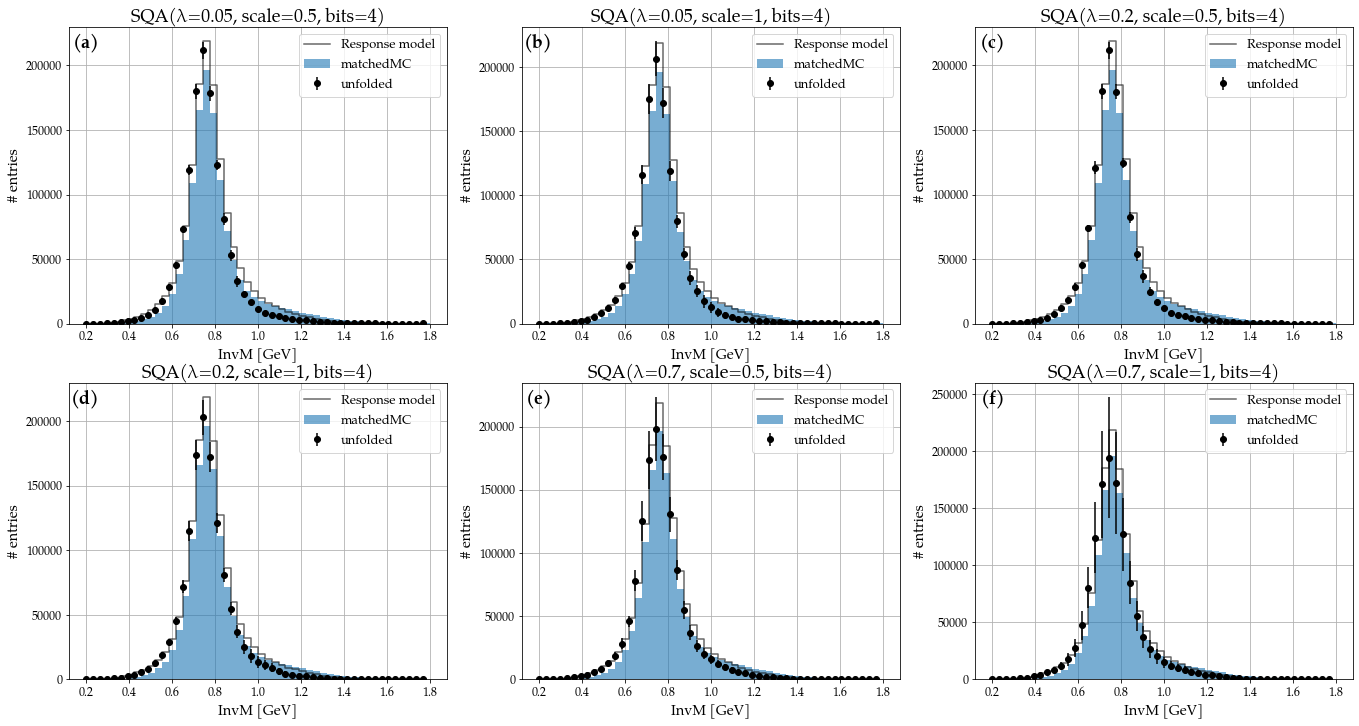

In [52]:
def model2label(model):
    return f"SQA(λ={model['weight_regularization']}, scale={model['encoder_scale']}, bits={model['n_bits']})"

# Build the plots grid to show them
n_cols = 3
axis = truth_bins[:-1]
n_models = len(models)
fig, axs = plt.subplots(n_models//n_cols if n_models%n_cols==0 else n_models//n_cols + 1, n_cols, figsize=(23, 12))
axs = axs.reshape(-1)
#fig.suptitle(f"Simulated Quantum Annealing Unfolding built from {config['histograms_path']}")

# Plot
for i, (model, result) in enumerate(zip(models, results)):
    # plot
    res_ax = axs[i]
    res_ax.step(truth_hist.axes[0].centers, truth_hist.view(), color="black", label="Response model", where="mid", alpha=0.6)
    res_ax.bar(hist_strict_invM_mc.axes[0].centers, hist_strict_invM_mc.view(), width=hist_strict_invM_mc.axes[0].widths, label="matchedMC", alpha=0.6)
    res_ax.errorbar(
        axis,
        result.solution,
        yerr=result.error,
        fmt="o",
        color="black",
        label="unfolded",
    )
    res_ax.legend(prop={"size": 13})
    res_ax.set_title(model2label(model))
    res_ax.set_xlabel("InvM [GeV]", fontsize="x-large")
    res_ax.set_ylabel("# entries", fontsize="x-large")
    res_ax.text(0.08, 0.98, f"({chr(i+97)})", transform=res_ax.transAxes, fontsize=18, fontweight='bold', va='top', ha='right')
    res_ax.set_ylim(0, None)

In [54]:
for i, (model, result) in enumerate(zip(models, results)):
    clean_solution = result.solution[2:]
    chi, p = chisquare(clean_solution, clean_expected)
    mape = get_mape(clean_solution, clean_expected)
    print(f"{chr(97+i)})\tchi = {chi:.3f} => p = {p}\tmape = {mape:.3f}%")

a)	chi = 63430.718 => p = 0.0	mape = 124.901%
b)	chi = 64554.137 => p = 0.0	mape = 125.534%
c)	chi = 67961.079 => p = 0.0	mape = 134.396%
d)	chi = 63558.758 => p = 0.0	mape = 133.034%
e)	chi = 65930.932 => p = 0.0	mape = 149.010%
f)	chi = 62113.829 => p = 0.0	mape = 148.263%


### Simulated Classical Annealing
Try with Simulated Classical annealing with different params

In [9]:
import itertools

nbins, rmin, rmax = config["hist"]["nbins"], config["hist"]["rmin"], config["hist"]["rmax"]

# Build params to search
params = {
    "weight_regularization" : [0.01, 0.7, 1, 1.5, 10],
    "encoder_scale" : [0.5],
    "n_bits" : [4, 8],
}
keys, values = zip(*params.items())
models = [dict(zip(keys, v)) for v in itertools.product(*values)]

# Perform the strict unfolding with many params
results = []
unfolder = Unfolder(data_strict_invM, statcov_strict, truth, reco, R)
for model in models:
    annealing_result = unfolder.unfold(SimulatedAnnealingBackend(**model, num_reads=100, encoder_use_alpha=False))
    # Save in results
    results.append(annealing_result)


/home/peguerosdc/development/thesis/unfolders/annealing/backend.py:243: RuntimeWarning: invalid value encountered in true_divide
  R_probabilities = np.where(xini > 0, np.divide(R, xini), 0)


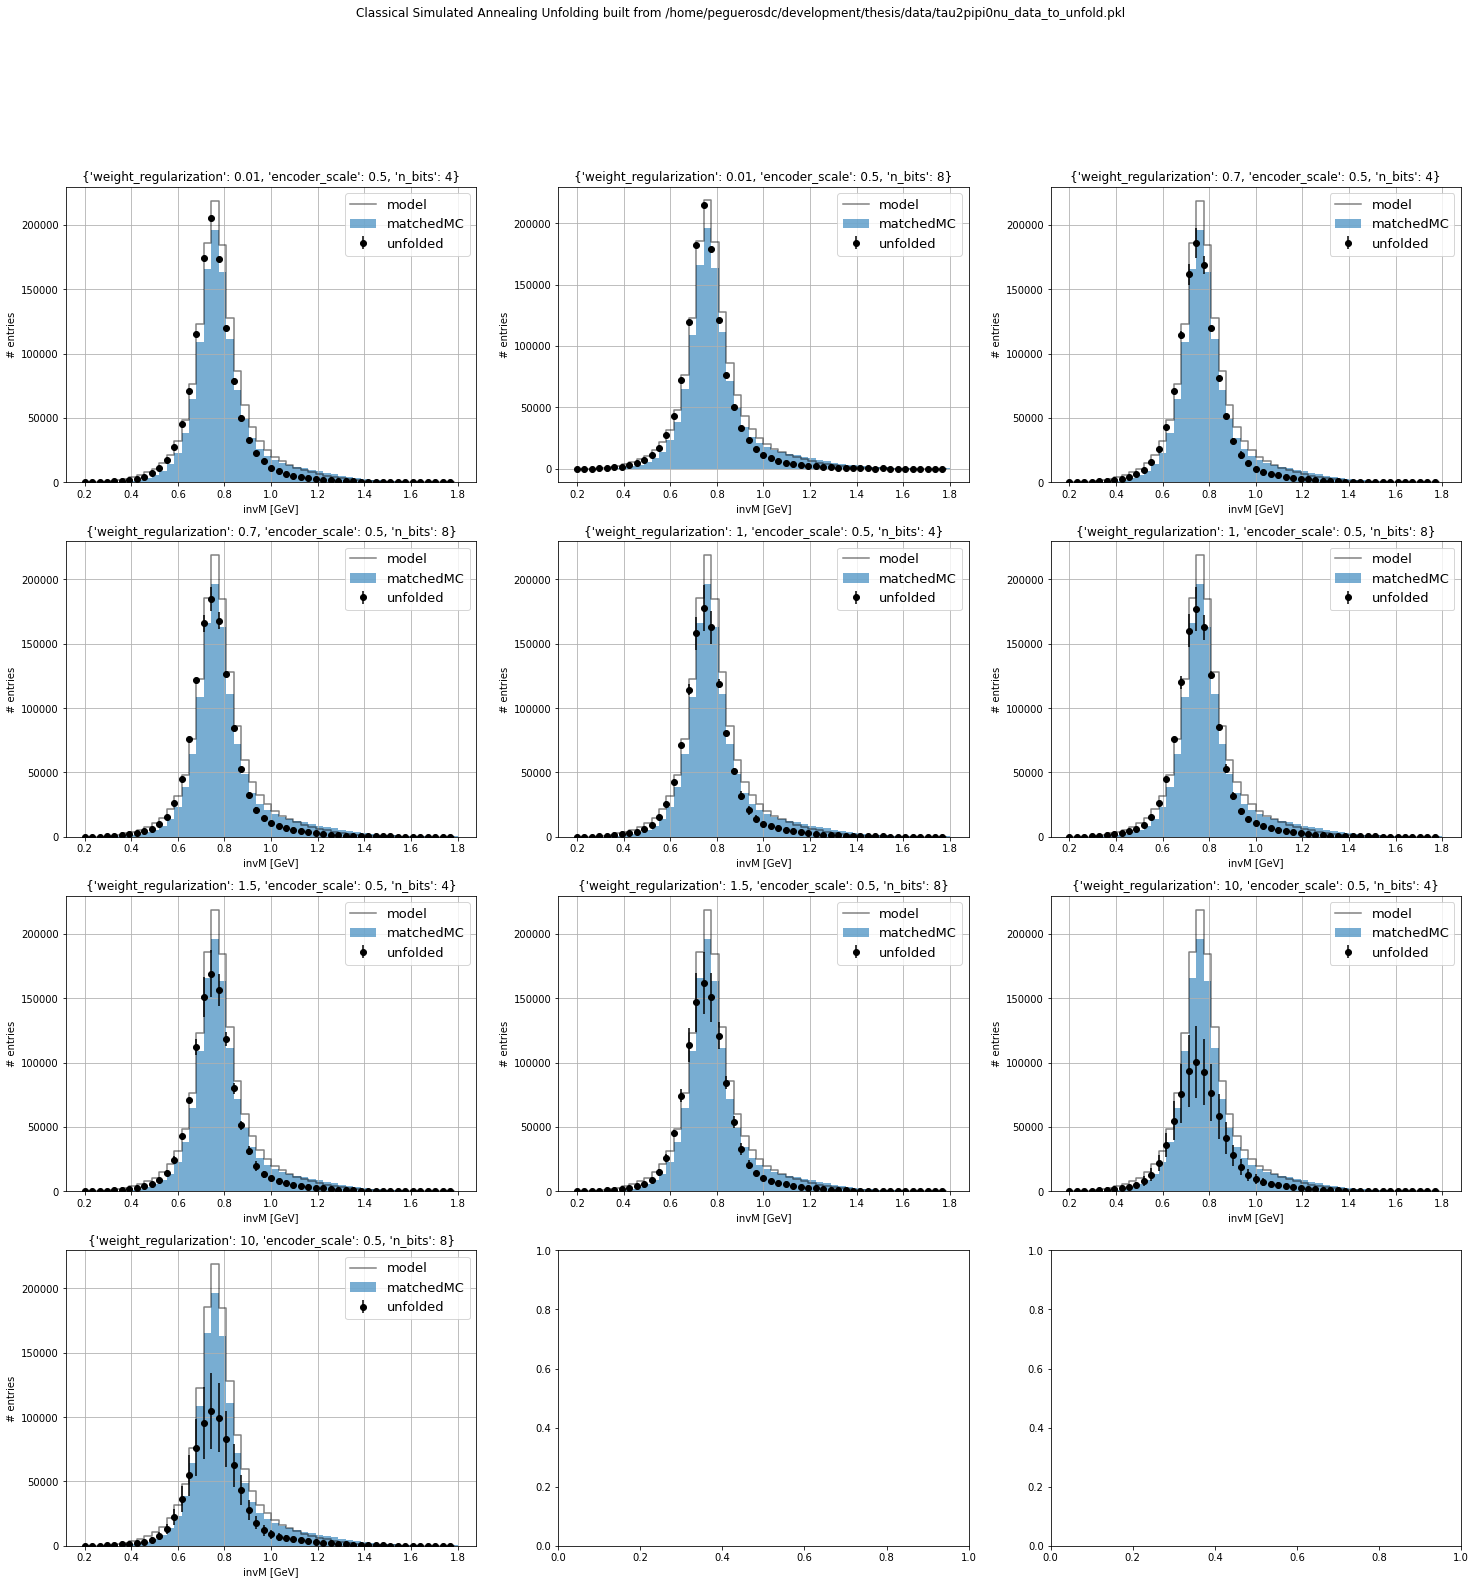

In [10]:
# Build the plots grid to show them
n_cols = 3
axis = truth_bins[:-1]
n_models = len(models)
fig, axs = plt.subplots(n_models//n_cols if n_models%n_cols==0 else n_models//n_cols + 1, n_cols, figsize=(25, 25))
axs = axs.reshape(-1)
fig.suptitle(f"Classical Simulated Annealing Unfolding built from {config['histograms_path']}")

# Plot
for i, (model, result) in enumerate(zip(models, results)):
    # plot
    res_ax = axs[i]
    res_ax.step(truth_hist.axes[0].centers, truth_hist.view(), color="black", label="model", where="mid", alpha=0.5)
    res_ax.bar(hist_strict_invM_mc.axes[0].centers, hist_strict_invM_mc.view(), width=hist_strict_invM_mc.axes[0].widths, label="matchedMC", alpha=0.6)
    res_ax.errorbar(
        axis,
        result.solution,
        yerr=result.error,
        fmt="o",
        color="black",
        label="unfolded",
    )
    res_ax.legend(prop={"size": 13})
    res_ax.grid()
    res_ax.set_title(f"{model}")
    res_ax.set_xlabel("invM [GeV]")
    res_ax.set_ylabel("# entries")

In [ ]:
# Define factors to try
factors = np.linspace(0.001, 5, 50)
# Create arrays to store info
norms = np.zeros(shape=factors.shape)
ress = np.zeros(shape=factors.shape)
# Unfold the normal histograms for each factor
for i, factor in enumerate(factors):
    results = []
    unfolder = Unfolder(data_strict_invM, statcov_strict, truth, reco, R)
    backend = SimulatedAnnealingBackend(n_bits=4, encoder_scale=0.5, num_reads=100, weight_regularization=factor, encoder_use_alpha=False)
    annealing_result = unfolder.unfold(backend)
    x_unfolded = annealing_result.solution
    # Get elements to plot
    norm, res = backend.compute_energy(x_unfolded, R, truth)
    res = res / factor
    # Store in the arrays
    norms[i] = norm
    ress[i] = res

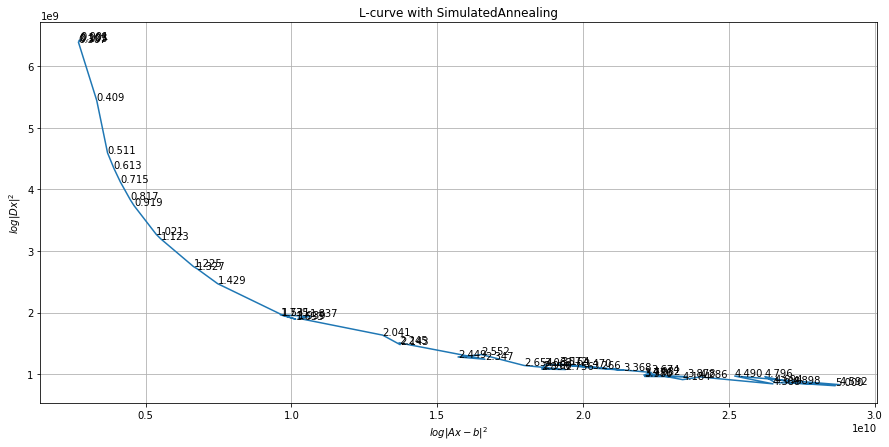

In [8]:
# Plot
plt.figure(figsize=(15, 7))
plt.plot(norms, ress)
for i, factor in enumerate(factors):
    plt.annotate(f"{factor:.3f}", (norms[i], ress[i]))

plt.title(f"L-curve with SimulatedAnnealing")
plt.xlabel("$log|Ax-b|^2$")
plt.ylabel("$log|Dx|^2$")
plt.grid()